In [ ]:
#from https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [95]:
#imports
from __future__ import division
import time
import datetime
import copy
from itertools import product
import operator
from collections import OrderedDict

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence

import altair as alt
alt.renderers.enable("notebook")
import ipywidgets as wid
from IPython.display import display, HTML

#seed for reproducibility
np.random.seed = 15

In [119]:
class ForestForTheTrees:
    
    DEFAULT_LEARNING_RATE = 1.
    
    def __init__(self):
        
        self.dataset = None
        self.x = None
        self.y = None
        self.feature_names = None
        self.feature_locs = None
        self.feature_ranges = {}
        self.target_type = None
        self.classifier_type = None
        self.classifier = None
        self.mean_prediction = None
        self.no_predictor_features = []
        self.oned_features = []   
        self.binned_data = None
        self.sample_size = None
        self.num_tiles = None
        self.quantiles = None
        self.learning_rate = self.DEFAULT_LEARNING_RATE
        self.predictions_base = None
        self.chart_components = {}
        self.explanation_components = {}
        self.base_explanation = []
        self.evaluation_details = []
        self.base_components = []
        self.explanation = []
        self.cache = {}
        
    def __init__(self, dataset, sample_size, num_tiles, quantiles, learning_rate):
        
        self.classifier_type = None
        self.classifier = None
        self.mean_prediction = None
        self.no_predictor_features = []
        self.oned_features = []   
        self.binned_data = None
        self.sample_size = sample_size #may be set to none here, will be handled in load_dataset()
        self.num_tiles = num_tiles
        self.quantiles = quantiles
        self.learning_rate = learning_rate
        self.predictions_base = None
        self.chart_components = {}
        self.explanation_components = {}
        self.base_explanation = []
        self.evaluation_details = []
        self.base_components = []
        self.explanation = []
        self.cache = {}
        self.load_dataset(dataset)
        
    def set_sample_size(self, new_size):
        self.sample_size = new_size
    
    def get_dataset(self, dataset):
        
        if dataset == "bike":
            def _datestr_to_timestamp(s):
                return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())

            dataLoad = pd.read_csv('data/bike.csv')
            dataLoad['dteday'] = dataLoad['dteday'].apply(_datestr_to_timestamp)
            dataLoad = pd.get_dummies(dataLoad, prefix=["weathersit"], columns=["weathersit"], drop_first = False)

            #de-normalize data to produce human-readable features.
            #Original range info from http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
            dataLoad["hum"] = dataLoad["hum"].apply(lambda x: x*100.)
            dataLoad["windspeed"] = dataLoad["windspeed"].apply(lambda x: x*67.)
            #convert Celsius to Fahrenheit
            dataLoad["temp"] = dataLoad["temp"].apply(lambda x: (x*47. - 8)*9/5 +32)
            dataLoad["atemp"] = dataLoad["atemp"].apply(lambda x: (x*66. - 16)*9/5 + 32)

            #rename features to make them interpretable for novice users
            feature_names_dict = {
                "yr":"First or Second Year", 
                "season":"Season", 
                "hr":"Hour of Day", 
                "workingday":"Work Day",
                "weathersit_2":"Misty Weather",
                "weathersit_3":"Light Precipitation",
                "weathersit_4":"Heavy Precipitation",
                "temp":"Temperature (F)",
                "atemp":"Feels Like (F)",
                "hum":"Humidity",
                "windspeed":"Wind Speed"
            }
            dataLoad = dataLoad.rename(mapper=feature_names_dict,axis=1) 
            features = feature_names_dict.values()

            return {
                "x": dataLoad[features].values,
                "y": dataLoad["cnt"],
                "feature_names": features,
                "feature_locs": {x:i for i,x in enumerate(features)},
                "target_type": "regression"
            }

    def bin_data(self):
    
        prediction_contributions = {}
        sample_data = pd.DataFrame(
            self.get_sample(self.x),
            columns = self.feature_names
        )
        for key in self.get_feature_pairs():
            tempH = np.digitize(
                sample_data.loc[:,key[0]],
                self.feature_ranges[key[0]]
            )-1.
            tempV = np.digitize(
                sample_data.loc[:,key[1]],
                self.feature_ranges[key[1]]
            )-1.
            prediction_contributions[key] = (tempV*len(self.feature_ranges[key[0]]) + tempH).astype(int)
        return prediction_contributions        
        
    def load_dataset(self, dataset):

        self.dataset = dataset
        data = self.get_dataset(self.dataset)
        self.x = data["x"]
        self.y = data["y"]
        self.feature_names = data["feature_names"]
        self.feature_locs = data["feature_locs"]
        self.target_type = data["target_type"]
        self.feature_ranges = {
            feature : self.get_quantiles(feature)
            for feature in self.feature_names
        } 
        if self.sample_size is None:
            self.sample_size = self.x.shape[0]
        self.binned_data = self.bin_data()    
            
    def build_base_model(self, num_estimators):

        self.model_type = "regression"
        self.classifier_type = GradientBoostingRegressor

        self.model = self.classifier_type(
            n_estimators=num_estimators, 
            max_depth=2, 
            learning_rate = self.learning_rate
        )
        self.model.fit(self.x, self.y)
        self.pred_y = self.model.predict(self.x)

    def get_model_accuracy(self):
        return r2_score(self.y, self.pred_y)    
        
    def _get_coordinate_matrix(self, lst, length, direction):
        if direction=="h":
            return lst*length
        else:
            return [item for item in lst\
             for i in range(length)]   

    def get_quantile_matrix(self, feat1, feat2):
        h = self._get_coordinate_matrix(
            list(self.feature_ranges[feat1]),
            len(self.feature_ranges[feat2]),
            "h"
        )
        v = self._get_coordinate_matrix(
            list(self.feature_ranges[feat2]),
            len(self.feature_ranges[feat1]),
            "v"
        )                      
        return h,v 

    def get_leaf_value(self, tree, node_position):
        node = tree.value[node_position]
        return node        

    def get_feature_pair_key(self, feat1, feat2):
        if self.feature_ranges[feat1].shape[0] == self.feature_ranges[feat2].shape[0]:
            #need stable order so keys with same number of quantiles appear in only one order
            return tuple(sorted([feat1, feat2]))
        elif self.feature_ranges[feat1].shape[0] > self.feature_ranges[feat2].shape[0]:
            return tuple([feat1, feat2])
        else:
            return tuple([feat2, feat1])        

    def get_quantiles(self, feat):
        loc = self.feature_locs[feat]
        if np.unique(self.x[:,loc]).shape[0] < 30 or type(self.x[0,loc]) is str: #is categorical/ordinal?
            return np.unique(self.x[:,loc])
        else:
            if self.quantiles:
                return np.around(
                    np.unique(
                        np.quantile(
                            a=self.x[:,loc],
                            q=np.linspace(0, 1, self.num_tiles)
                        )
                    ),
                    1)
            else:
                return np.around(
                    np.linspace(
                        np.min(self.x[:,loc]), 
                        np.max(self.x[:,loc]),
                        self.num_tiles
                    )
                    ,1)  
            
    def reduce_to_1d(self, arr, threshold, direction):
        if direction == "h":
            reduced_arr = arr - arr[:,0].reshape(-1,1)
        else:
            reduced_arr = arr - arr[0,:].reshape(1,-1)
        return (np.max(np.abs(reduced_arr))/np.max(np.abs(arr))) <= threshold               
        
    def get_sample(self, arr):
        return arr[:self.sample_size]
    
    def get_predictions_base(self):
        return np.full((self.sample_size,1), np.mean(self.y))
    
    def get_empty_sample(self, size = None):
        return np.full((self.sample_size if size is None else size,1), 0)
    
    def get_explanation_accuracy(self, explanation_predictions):
        return r2_score(self.get_sample(self.pred_y), explanation_predictions)
        
    def get_prediction_contributions(self, chart, data_positions):
        return np.take(chart, data_positions)
    
    def sum_arrays(self, temp_outputs, keyMain, keyAdd, arr_to_add):
        return temp_outputs[keyMain]["output"]\
    + temp_outputs[keyAdd][arr_to_add].reshape(
            temp_outputs[keyMain]["output"].shape[0]
            if(keyMain[1]==keyAdd[1] or keyMain[1]==keyAdd[0])
            else 1,-1
        )
    
    def _drop_alternate_outputs(self,component):
        return {"output": component["output"]}
    
    def _get_prediction_contributions_df(self, components, explanation):
        return np.hstack(
            tuple(
                [
                    self.get_prediction_contributions(
                        components[expKey]["output"],
                        self.binned_data[expKey]
                    ).reshape(-1, 1)\
                    for expKey in explanation                    
                ]
            )
        )
    
    def _get_prediction_contributions_by_key(self, components, explanation):
        return {
            expKey : 
            self.get_prediction_contributions(
                components[expKey]["output"],
                self.binned_data[expKey]
            ) for expKey in explanation
        }
    
    def evaluate_explanation(self):
        return self._evaluate_single_explanation(self.chart_components, self.explanation)

    def _evaluate_single_explanation(self, components, explanation):
        
        return self.get_explanation_accuracy(
            self.predictions_base +\
            np.sum(
                np.array(
                    self._get_prediction_contributions_by_key(
                        components,
                        explanation
                    ).values()
                ), 
                axis = 0
            ).reshape(-1,1)
        )
    
    def _get_parallel_coordinate_columns(self, explanation, cumulative):
        #make these strings because Altair doesn't like a tuple as a key and turns it into a list
        return (["mean y"] if cumulative else [])\
    + [x[0] + "," + x[1] for x in explanation]\
    + (["prediction"] if cumulative else [])
    
    def _get_altair_data_type(self,feature_name, abbreviation = True):
        if self.feature_ranges[feature_name].shape[0] == self.num_tiles:
            return "Q" if abbreviation else "quantitative"
        else:
            return "O" if abbreviation else "ordinal"    
    
    def _get_datapoint_contributions(self, components, explanation):
        contributions = self._get_prediction_contributions_df(components, explanation)
        #raw contributions
        arr = np.hstack(
            (
                self.get_empty_sample().reshape(-1,1),
                contributions.reshape(self.sample_size, -1),
                self.get_sample(self.pred_y).reshape(-1,1),
                np.array([0. for x in range(self.sample_size)]).reshape(-1,1)
            )
        )
        
        #cumulative version
        arr_cum = np.cumsum(
            np.hstack(
                (
                    self.get_predictions_base().reshape(-1,1),
                    contributions.reshape(self.sample_size,-1)
                )
            ),
            axis = 1
        )
        
        arr_cum = np.hstack(
            (
                arr_cum,
                self.get_sample(self.pred_y).reshape(-1,1),
                np.array([1. for x in range(self.sample_size)]).reshape(-1,1)
            )
        )

        arr_df = pd.DataFrame(
            arr,
            columns = self._get_parallel_coordinate_columns(explanation, True) + ["view"]
        )
        
        #combine arrays
        arr_cum_df = pd.DataFrame(
            arr_cum,
            columns = self._get_parallel_coordinate_columns(explanation, True) + ["view"]
        )
        
        #generate datapoint id columns
        arr_df = arr_df.reset_index(drop = False)
        arr_cum_df = arr_cum_df.reset_index(drop = False)
        datapoints = pd.concat([arr_df, arr_cum_df])
        
        #couldn't do this earlier, as you can't vstack a mixed type array
        datapoints["view"] = datapoints["view"].apply(lambda x:\
                                                      'Predictions by Chart'\
                                                      if x < 1. else\
                                                      'Cumulative Predictions'\
                                                     )
        #calculate explanation loss
        datapoints["explanation_loss"] = np.abs( #otherwise the chart is hard to read with 0 in the middle of the axis
            datapoints.loc[:,"prediction"] - datapoints.iloc[:,-3]#last cumulative column
        )
        
        #datapoints = datapoints.reset_index(drop = False)
        datapoints["prediction_index"] = datapoints["prediction"]
        datapoints = datapoints.melt(
            id_vars = ['index', "prediction_index", "view", "explanation_loss"],
            var_name = 'component',
            value_name = 'contribution'
        )
        
        #rename prediction again
        datapoints = datapoints.rename({"prediction_index" : "prediction"}, axis = 1)

        #drop fake columns for "Predictions by Chart"
        datapoints = datapoints[
            (datapoints["view"] == "Cumulative Predictions")
            | (~datapoints["component"].isin(["prediction", "mean y", "explanation_loss"]))
        ]
        
        #build sort column for Altair
        datapoints["sort"] = datapoints["component"].apply(lambda x:
                                                           self._get_parallel_coordinate_columns(
                                                               explanation,
                                                               True
                                                           ).index(x)
                                                          )   
        return datapoints

    def copy_chart_components(self):
        return copy.deepcopy(self.chart_components)  
    
    def get_feature_pairs(self):
        return [
            self.get_feature_pair_key(key[0], key[1])
            for key in [tuple(t) for t in product(self.feature_names, repeat = 2)]
        ]       

    def rollup_components(self, explanation):
        temp_outputs = self.copy_chart_components()
        for keyRollup in [k for k in self.chart_components.iterkeys() if k not in explanation]:
            hUsed = False
            vUsed = False
            for keyExisting in explanation:
                if (keyRollup[1] == keyExisting[0] or keyRollup[1] == keyExisting[1]) and not hUsed:
                    hUsed = True
                    if vUsed:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_HReduced"
                        )
                        break
                    else:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_H"
                        )                           
                elif (keyRollup[0] == keyExisting[0] or keyRollup[0] == keyExisting[1]) and not vUsed:
                    vUsed = True
                    if hUsed:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_VReduced"
                        )                          
                        break
                    else:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_V"
                        )  
        return temp_outputs   
    
    def visualize_estimator(self, estimator_nums, try_collapse = False,
                            print_function_text = True, auto_display = True):
        
        estimators = [self.model.estimators_[estimator_nums]] if type(estimator_nums) is int\
        else [x for i,x in enumerate(self.model.estimators_) if i in estimator_nums] 
        
        chart_components,\
        chart_indices,\
        _,\
        _,\
        function_texts = self._extract_components(
            try_collapse, 
            estimators,
            print_function_text
        )
        
        if print_function_text:
            if len(function_texts) == 1:
                for x in [x for x in function_texts.values()[0]["function_texts"]]:
                    print x
            else:
                for x in [x["function_texts"] for x in function_texts.values()]:
                    for text in x:
                        print x[0]
        chart = self._visualize_components(
            chart_components.keys(),
            chart_components,
            None,
            chart_indices,
            False, 
            300
        )
        if auto_display:
            display(chart)
        return chart
    
    def _get_function_text(self, decision_func_dict):
        
        def _get_left_right_text(op, le, gt):
            if op == operator.le:
                return " is less than or equal to ", str(round(le,1)), str(round(gt,1))
            else:
                return " is greater than ", str(gt), str(le)
                
        
        if "feature_name" in decision_func_dict: #1-deep
            
            comparison_text, left, right = _get_left_right_text(
                decision_func_dict["operator"],
                decision_func_dict["prob_le"],
                decision_func_dict["prob_gt"]
            )
            
            text = "If " + decision_func_dict["feature_name"] + comparison_text\
            + str(round(decision_func_dict["threshold"],1)) + " then " + left\
            + " else " + right + ". "
            
            return text
        
        else: #2-deep
            comparison_text_1, left_1, right_1 = _get_left_right_text(
                decision_func_dict["operator_1"],
                0,
                0
            )

            comparison_text_2, left_2, right_2 = _get_left_right_text(
                decision_func_dict["operator_2"],
                decision_func_dict["prob_le"],
                decision_func_dict["prob_gt"]
            ) 
            
            
            text = "If " + decision_func_dict["feature_name_1"] + comparison_text_1\
            + str(round(decision_func_dict["threshold_1"],1)) + " then proceed. If "\
            + decision_func_dict["feature_name_2"] + comparison_text_2\
            + str(round(decision_func_dict["threshold_2"],1)) + " then " + left_2 + " else " + right_2 + ". "
            
            return text
    
    def extract_components(self, collapse_1d = True, return_text = False):
        
        self.chart_components,\
        self.chart_indices,\
        self.no_predictor_features,\
        self.oned_features,\
        self.estimator_texts = self._extract_components(collapse_1d, self.model.estimators_, return_text)
        
        self.predictions_base = self.get_predictions_base()
        
        #get the full explanation and store it. one reason for this is so that
        #charts can also be sorted appropriately
        #don't save explanation components as they will be the same as chart_components
        self.base_explanation, _, _\
        = self._explain(1., None)        
        
    def _extract_components(self, collapse_1d, estimators, return_text):

        #generate data structure for pairwise charts
        feature_pairs = {
            key : {
                "map":None,
                "predicates":[],
                "function_texts":[]
            }
            for key in self.get_feature_pairs()
        }      

        for key, value in feature_pairs.iteritems():
            h, v = self.get_quantile_matrix(key[0], key[1])
            value["map"] = np.array(
                [
                    {
                        key[0] : x,
                        key[1] : y
                    }
                    for x,y in zip(h,v)
                ]
            ).reshape(len(self.feature_ranges[key[1]]), len(self.feature_ranges[key[0]]))

        for modelT in estimators:
            curr_model = modelT[0]
            feature_ids = {
                i : {
                    "number":x,
                    "name":self.feature_names[x]
                } for i,x in enumerate(list(curr_model.tree_.feature))
                if x >= 0
            } #-2 means leaf node

            #for 1-layer trees
            if curr_model.tree_.feature[1] < 0:
                feature_pair_key = self.get_feature_pair_key(
                    feature_ids[0]["name"],
                    feature_ids[0]["name"]
                )
                decision_func_dict = {
                    "feature_name": feature_ids[0]["name"],
                    "threshold": curr_model.tree_.threshold[0],
                    "operator": operator.le,
                    "prob_le": self.get_leaf_value(curr_model.tree_, 1),
                    "prob_gt": self.get_leaf_value(curr_model.tree_, 2)
                }       
                #build the predictive function used in the decision tree
                def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                    if decision_func_dict["operator"](\
                                                        data_case[decision_func_dict["feature_name"]],\
                                                        decision_func_dict["threshold"]\
                                                       ):
                        return decision_func_dict["prob_le"]
                    else:
                        return decision_func_dict["prob_gt"]        
            else:
                for node_position in [1,4]: #positions for left and right nodes at layer 2
                    if node_position in feature_ids:
                        feature_pair_key = self.get_feature_pair_key(
                            feature_ids[0]["name"], 
                            feature_ids[node_position]["name"]
                        )
                        #get the decision rules
                        decision_func_dict = {
                            "feature_name_1": feature_ids[0]["name"],
                            "threshold_1": curr_model.tree_.threshold[0],
                            "operator_1": operator.le if node_position == 1 else operator.gt,

                            "feature_name_2": feature_ids[node_position]["name"],
                            "threshold_2": curr_model.tree_.threshold[node_position],
                            "operator_2": operator.le,

                            "prob_le": self.get_leaf_value(curr_model.tree_, node_position+1),
                            "prob_gt": self.get_leaf_value(curr_model.tree_, node_position+2)
                        }
                        #build the predictive function used in the decision tree
                        def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                            if decision_func_dict["operator_1"](\
                                                                data_case[decision_func_dict["feature_name_1"]],\
                                                                decision_func_dict["threshold_1"]\
                                                               ):
                                if decision_func_dict["operator_2"](\
                                                                    data_case[decision_func_dict["feature_name_2"]],\
                                                                    decision_func_dict["threshold_2"]\
                                                                   ):
                                    return decision_func_dict["prob_le"]
                                else:
                                    return decision_func_dict["prob_gt"]
                            else:
                                return 0.

                    else: #asymmetric tree, this is a leaf node
                        feature_pair_key = self.get_feature_pair_key(
                            feature_ids[0]["name"], 
                            feature_ids[0]["name"]
                        )
                        decision_func_dict = {
                            "feature_name": feature_ids[0]["name"],
                            "threshold": curr_model.tree_.threshold[0],
                            "operator": operator.le if node_position == 1 else operator.gt,
                            "prob": curr_model.tree_.value[node_position]
                        }
                        #build the predictive function used in the decision tree
                        def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                            if decision_func_dict["operator"](\
                                                                data_case[decision_func_dict["feature_name"]],\
                                                                decision_func_dict["threshold"]\
                                                               ):
                                return decision_func_dict["prob"]
                            else:                         
                                return 0.                 

                    feature_pairs[feature_pair_key]["predicates"].append(dt_predicate)
                    if return_text:
                        feature_pairs[feature_pair_key]["function_texts"].append(
                            self._get_function_text(
                                decision_func_dict
                            )
                        )

        #now calculate output array for each feature pair
        for key, value in feature_pairs.iteritems():
            arrs = []
            for predicate in value["predicates"]:
                f = np.vectorize(predicate)
                arrs.append(f(value["map"]))
            if len(arrs) > 0:
                #details of vote aggreggation method for random forest
                #https://stats.stackexchange.com/questions/127077/random-forest-probabilistic-prediction-vs-majority-vote
                value["output"] = np.sum(np.stack(arrs, axis=-1), axis=-1)*self.learning_rate 
            else:
                value["output"] = None

        #build chart data
        for key, value in feature_pairs.iteritems():
            h,v = self.get_quantile_matrix(key[0], key[1])
            value["h_indices"] = h
            value["v_indices"] = v    

        no_predictor_features = []
        oned_features = []
        chart_data = {}
        for key, value in feature_pairs.iteritems(): 
            newKey = key
            if value["output"] is None:
                no_predictor_features.append(key)
                value["removed"] = True
            else:          
                if collapse_1d:
                    if self.reduce_to_1d(value["output"], 0., "v"):
                        newKey = key[1]
                        value["output"] = value["output"][0,:]
                        value["h_indices"] = self.feature_ranges[newKey]
                        value["v_indices"] = None
                        value["1d_key"] = newKey
                        value["removed"] = True
                        oned_features.append(key)                 
                    elif self.reduce_to_1d(value["output"], 0., "h"):
                        newKey = key[0]
                        value["output"] = value["output"][:,0]
                        value["h_indices"] = self.feature_ranges[newKey]
                        value["v_indices"] = None
                        value["1d_key"] = newKey
                        value["removed"] = True
                        oned_features.append(key)

        #do another loop through chart_data to push 1d charts into 2d
        if collapse_1d:
            for value in feature_pairs.itervalues():
                if value["v_indices"] is None:
                    key = value["1d_key"]
                    #get list of charts with this feature
                    matchList = sorted([{"key": kInner, "feature_importance": np.std(vInner["output"])}\
                                        for kInner, vInner in feature_pairs.iteritems()\
                                        if "removed" not in vInner and key in kInner],\
                                       key=lambda x: x["feature_importance"], reverse=True)

                    if len(matchList) > 0:
                        matchKey = matchList[0]["key"]
                        feature_pairs[matchKey]["output"] = feature_pairs[matchKey]["output"]\
                        + value["output"].reshape(\
                                                  -1 if key == matchKey[1] else 1,\
                                                  -1 if key == matchKey[0] else 1\
                                                 )

        #one last loop to generate the horizontal and vertical components
        for key, value in feature_pairs.iteritems():
            if "removed" in value:
                pass
            else:
                value["output_H"] = np.mean(value["output"], axis=1).reshape(-1,1)
                value["output_V"] = np.mean(value["output"], axis=0).reshape(1,-1)
                value["output_HReduced"] = np.mean(value["output"] - value["output_V"].reshape(1,-1), axis=1)\
                .reshape(1,-1)
                value["output_VReduced"] = np.mean(value["output"] - value["output_H"].reshape(-1,1), axis=0)\
                .reshape(-1,1)

        #remove deleted keys
        feature_pairs = {key:val for key, val in feature_pairs.iteritems() if "removed" not in val}
        feature_pairs = OrderedDict(sorted(feature_pairs.items(),\
                                            key=lambda x: np.std(x[1]["output"]), reverse=True))
        chart_components = {
            key: {
                "output" : val["output"],
                "output_VReduced" : val["output_VReduced"],
                "output_H" : val["output_H"],
                "output_HReduced" : val["output_HReduced"],
                "output_V" : val["output_V"]
            } for key, val in feature_pairs.iteritems()
        }

        chart_indices = {
            key: {
                "h_indices" : val["h_indices"],
                "v_indices" : val["v_indices"]
            } for key, val in feature_pairs.iteritems()
        }
        
        function_texts = {
            key : {
                "function_texts" : val["function_texts"]
            } for key, val in feature_pairs.iteritems()
        } if return_text else None
        
        return chart_components, chart_indices, no_predictor_features, oned_features, function_texts
        
    def _explain(self, fidelity_threshold = 1., rollup = None):

        explanation = []   
        explanation_components = {}
        evaluation_details = [
            {
                "score": self.get_explanation_accuracy(
                    self.predictions_base
                )
            }
        ]
        
        while evaluation_details[-1]["score"] < fidelity_threshold\
        and len(explanation) < len(self.chart_components):
            current_details = {}
            temp_outputs = {}
            keys_to_evaluate = [key for key in self.chart_components.iterkeys() if key not in explanation]
            for key in keys_to_evaluate:
                #roll up other keys
                current_explanation = explanation+[key]
                temp_outputs[key] = self.rollup_components(current_explanation)\
                if rollup == "advanced"\
                else self.copy_chart_components()

                current_details[key] = self._evaluate_single_explanation(temp_outputs[key], current_explanation)

            #get key with highest fidelity score
            best_key = max(
                current_details.iterkeys(),\
                key = (lambda key: current_details[key])
            )
            explanation.append(best_key)
            current_details["best_key"] = best_key

            if rollup == "simple":
                temp_outputs[best_key] = self.rollup_components(explanation)
                current_details[best_key] = self._evaluate_single_explanation(temp_outputs[best_key], explanation)

            
            current_details["score"] = current_details[best_key]
            evaluation_details.append(current_details)
            explanation_components = {k : self._drop_alternate_outputs(v)\
                                      for k, v in temp_outputs[best_key].iteritems()}
        return explanation, explanation_components, evaluation_details
    
    def explain(self, fidelity_threshold = 1., rollup = None):
        self.explanation, self.explanation_components, self.evaluation_details\
        = self._explain(fidelity_threshold, rollup)
        
    def cache_visualize_components(self, start = 1, end = 100, step = 1):
        self.cache["play_components"] = []
        for i in range(start, end+1, step):
            ft = ForestForTheTrees(
                dataset = self.dataset,
                sample_size = self.sample_size,
                num_tiles = self.num_tiles,
                quantiles = self.quantiles,
                learning_rate = self.learning_rate
            )
            ft.build_base_model(i)
            ft.extract_components(True)
            self.cache["play_components"].append(
                {
                    "explanation" : ft.base_explanation,
                    "components" : ft.chart_components,
                    "chart_indices" : ft.chart_indices
                }
            )
        
    def cache_visualize_datapoints(self):
        
        minimal = self._get_datapoint_contributions(
            self.explanation_components,
            self.explanation
        )
        
        full = self._get_datapoint_contributions(
            self.explanation_components,
            self.base_explanation
        )
        
        minimal["explanation"] = "minimal"
        full["explanation"] = "full"
        
        self.cache["datapoints"] = pd.concat([minimal, full])
        
    def visualize_datapoints(self, cumulative = False, num_datapoints = 50, explanation_type = "minimal",
                            color_encoding = "prediction", auto_display = True):
        output = self._visualize_datapoints(explanation_type, cumulative, num_datapoints, color_encoding)
        if auto_display:
            display(output)
        return output
    
    def _visualize_datapoints(self, explanation_type, cumulative, num_datapoints, color_encoding):
        
        explanation_to_visualize = self.explanation\
        if len(self.explanation) > 0 and explanation_type == "minimal"\
        else self.base_explanation        
        
        if "datapoints" in self.cache and self.cache["datapoints"] is not None:
            datapoints = self.cache["datapoints"]
            datapoints = datapoints[datapoints["explanation"] == explanation_type]
        
        else:            
            datapoints = self._get_datapoint_contributions(
                self.explanation_components,
                explanation_to_visualize
            )
        
        unique_datapoint_ids = np.unique(datapoints.loc[:,"index"])
        sample_datapoint_ids = np.random.choice(unique_datapoint_ids, num_datapoints, replace = False)
        datapoints = datapoints[datapoints["index"].isin(sample_datapoint_ids)]
        datapoints = datapoints[datapoints["view"] == ("Cumulative Predictions"\
                                                       if cumulative\
                                                       else "Predictions by Chart")
                               ]
        
        df_raw = pd.DataFrame(self.x, columns = self.feature_names)
        df_raw["prediction"] = self.pred_y
        df_raw = df_raw.reset_index(drop = False)
        df_raw = df_raw[df_raw["index"].isin(sample_datapoint_ids)]       
        
        brush = alt.selection_multi()
        chart = alt.Chart(data = datapoints)\
        .mark_line()\
        .encode(
            x = alt.X(
                field = 'component',
                type = 'nominal',
                axis = alt.Axis(labelAngle = -30),
                sort = self._get_parallel_coordinate_columns(explanation_to_visualize, cumulative)
            ),
            y ='contribution:Q',
            color = alt.condition(
                brush,
                alt.Color(
                    field = color_encoding,
                    type = "quantitative",
                    scale = alt.Scale(scheme = "plasma")
                ),
                alt.value("lightgray")
            ),
            opacity = alt.condition(
                brush,
                alt.value(1.0),
                alt.value(0.2)
            ),
            tooltip = [
                alt.Tooltip(x+":"+self._get_altair_data_type(x))
                for x in self.feature_names
            ] + [
                alt.Tooltip(x+":Q")
                for x in ["prediction", "explanation_loss"]                
            ],         
            detail = 'index:N',
            order = "sort:N"
        ).transform_lookup(
            lookup = 'index',
            from_ = alt.LookupData(
                data = df_raw, 
                key = 'index',
                fields = self.feature_names
            )
        ).properties(
            height = 300,
            width = 800
        ).add_selection(
            brush
        )
        
        return chart
        
    def visualize_components(self, plot_points = True, chart_size = 150):
        if len(self.explanation) > 0:
            explanation_to_visualize = self.explanation
            components = self.explanation_components
        else:
            explanation_to_visualize = self.base_explanation
            components = self.chart_components
        return self._visualize_components(
            explanation_to_visualize,
            components,
            None,
            self.chart_indices,
            plot_points,
            chart_size
        )
    
    def play_components(self, cache_id):
        output = self._visualize_components(
            #-1 deals with the fact that list is zero-based but number of trees starts at 1
            self.cache["play_components"][cache_id-1]["explanation"],
            self.cache["play_components"][cache_id-1]["components"],
            self.cache["play_components"][cache_id-2]["components"] if cache_id > 1 else None,
            self.cache["play_components"][cache_id-1]["chart_indices"],
            False,
            150
        )
        display(output)
        return output
        
    def _visualize_components(self, explanation, components, ref_components, chart_indices,
                              plot_points, chart_size):
        i = 1
        rows = []
        charts = []
        self.temp_components = components.copy()
        self.temp_indices = chart_indices.copy()
        for key in explanation:
            
            chart_df = pd.DataFrame(
                np.hstack(
                    (
                        np.array(chart_indices[key]["h_indices"]).reshape(-1,1),
                        np.array(chart_indices[key]["v_indices"]).reshape(-1,1),
                        components[key]["output"].ravel().reshape(-1,1),
                        
                        ref_components[key]["output"].ravel().reshape(-1,1)\
                        if ref_components is not None and key in ref_components\
                        else self.get_empty_sample(len(chart_indices[key]["h_indices"])).reshape(-1,1)
                    )
                ),
                columns = ["h_indices", "v_indices", "contributions", "ref_contributions"]
            )
            
            #figure out cells that should be highlighted
            chart_df["is_changed"]\
            = chart_df.apply(lambda x:
                             abs(x["ref_contributions"] - x["contributions"])/abs(x["contributions"]+0.001) > 0.05\
                             or (x["contributions"] != 0. and key not in ref_components)#new chart this step
                             if ref_components is not None else False,
                             axis = 1
                            )

            y_encoding = alt.Y(
                field = "v_indices",
                type = "ordinal",
                sort = "descending",
                axis = alt.Axis(title = key[1])
            )                

            x_encoding = alt.X(
                field = "h_indices",
                type = "ordinal",
                sort = "ascending",
                axis = alt.Axis(
                    title = key[0],
                    labelAngle = 0,
                    labelOverlap = "greedy"
                )
            )

            color_encoding = alt.Color(
                field = "contributions",
                type = "quantitative",
                scale = alt.Scale(
                    scheme = "redblue",
                    domain = [
                        np.min([np.min(x["output"]) for x in self.explanation_components.values()]),
                        np.max([np.max(x["output"]) for x in self.explanation_components.values()])
                    ]
                ),
                legend = alt.Legend(title = "Votes")
            )
            
            tooltip_encoding = [
                alt.Tooltip('h_indices:O', title = key[0]),
                alt.Tooltip('v_indices:O', title = key[1]),
                alt.Tooltip("contributions:Q", title = "Contribution")
            ]

            chart = alt.Chart(data = chart_df).mark_rect()

            chart = chart.encode(
                x = x_encoding, 
                y = y_encoding, 
                color = color_encoding,
                tooltip = tooltip_encoding
            ).properties(
                width = chart_size, 
                height = chart_size
            )

            if plot_points:
                point_df = pd.DataFrame(self.x[np.random.choice(self.x.shape[0],500,replace = False),:],\
                                  columns = self.feature_names)
                points = alt.Chart(point_df).mark_circle(
                    color = 'black',
                    size = round(chart_size/50,0)
                ).encode(
                    x = alt.X(field = key[0], type = "quantitative", sort = "ascending", axis = None),
                    y = alt.Y(field = key[1], type = "quantitative", sort = "ascending", axis = None)
                ).properties(width = chart_size, height = chart_size)
                chart = chart + points
                #chart = chart.resolve_scale(x = "independent", y = "independent")
                
            elif ref_components is not None:
                changes = alt.Chart(data = chart_df[chart_df["is_changed"]]).mark_circle(size = 8).encode(
                    x = alt.X(field = "h_indices", type = "ordinal", sort = "ascending", axis = None),
                    y = alt.Y(field = "v_indices", type = "ordinal", sort = "descending", axis = None)
                ).properties(width = chart_size, height = chart_size)
                chart = chart + changes
                chart = chart.resolve_scale(y = "independent")
                
            charts.append(chart)
            if len(charts) == 4 or i == len(explanation):
                rows.append(alt.hconcat(*charts))
                charts = []
            i += 1
            
        output = alt.vconcat(*rows).configure_scale(
                bandPaddingInner = 0
            )
        return output

In [120]:
f2t = ForestForTheTrees(dataset = "bike", sample_size = None, num_tiles = 40, quantiles = False, learning_rate = 1.)
f2t.build_base_model(300)
f2t.extract_components(True, False)
f2t.explain(.95, None)

In [123]:
#TO DO cache to file
#cache output of the longer-running calculations so that visualizations can be run more quickly
f2t.cache_visualize_datapoints()
f2t.cache_visualize_components(start = 1, end = 10, step = 1)

In [7]:
play_control = wid.Play(
    interval = 3000,
    value = 1,
    min = 1,
    max = 10,
    step = 1,
    description = "Press play"
)
play_slider = wid.IntSlider(
    value = 1,
    min = 1,
    max = 10,
    step = 1,
    continuous_update = False,
    description = "# of trees"
)
wid.jslink((play_control, 'value'), (play_slider, 'value'))
ui = wid.HBox([play_control, play_slider])
output = wid.interactive_output(
    f2t.play_components,
    {"cache_id" : play_control}
)
display(ui, output)

SEJveChjaGlsZHJlbj0oUGxheSh2YWx1ZT0xLCBkZXNjcmlwdGlvbj11J1ByZXNzIHBsYXknLCBpbnRlcnZhbD0zMDAwLCBtYXg9MTAsIG1pbj0xKSwgSW50U2xpZGVyKHZhbHVlPTEsIGNvbnTigKY=


Output()

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdWaWV3Jywgb3B0aW9ucz0oKCdDdW11bGF0aXZlIFByZWRpY3Rpb24nLCBUcnVlKSwgKCdDb250cmlidXRpb25zIGJ5IEZlYXTigKY=


Output()

# How Do Gradient Boosted Trees Capture Patterns in a Dataset?
## A Visual Analysis of Complex Machine Learning Models with some new ideas for interpretability 

# Goal

The purpose of this notebook is to provide a visual overview of how one particular machine learning model (Gradient Boosting Trees) learns the structure in a dataset. It will look at the complete model through a few different lenses, and also watch the model build its own internal structure. The goal is to help the curious reader develop an intuition for why the model makes certain predictions, and where it is imperfect. While some of these conclusions are specific to Gradient Boosting Trees, the reader will also find some novel tools for interpreting machine learning models more broadly.

In that sense, this notebook is aimed at an audience that has some exposure to data analysis, but are not necessarily experts in machine learning. This is also an interactive notebook, so in a lot of places the reader will be able to use sliders, dropdowns, and other widgets to modify the visualization to further develop their intuition. 

The bulk of the code for this notebook is contained in hidden cells above. A fair amount of data manipulation goes into visualizing these models, but the point here is not to focus on those details. For those who are interested, the code above is collected into a library called [ForestForTheTrees](https://www.github.com/MattJBritton/ForestForTheTrees). You'll see that many of the visualizations are called from a ForestForTheTrees instance generated from this library. The library is under active development and is in an alpha version. Collaborators are welcome! 

This notebook was developed using Python and the Python data science stack, particularly [numpy], [pandas], and [scikit-learn]. [Altair] was used for all of the visualizations.

# Brief Introduction to Machine Learning

If you're not a data scientist, you might be most familiar with machine learning from the cool and creepy things it does that get coverage on news and social media. Things like [helping doctors diagnose breast cancer](https://ai.googleblog.com/2018/04/an-augmented-reality-microscope.html), [making new celebrity faces](https://research.nvidia.com/publication/2017-10_Progressive-Growing-of), [watching us from the skies](https://www.goodreads.com/book/show/40796190-eyes-in-the-sky?ac=1&from_search=true) and [potentially sending you to prison](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). While this is not a thinkpiece on the future of AI (an industry that, if it continues at the current rate, may employ so many people that it obviates its own concerns), it's fair to say that it would be easy to look at the news and glean that machine learning's primary business is to knock off another treasured "well at least only humans can do X" every day.

And certainly, anyone reviewing the latest machine learning journals would find plenty of fodder for the belief that researchers are working hard to remove humans, even developers, from the equation. How else to explain research into [automated data cleaning](https://dl.acm.org/citation.cfm?id=2750549), [automated feature extraction](https://arxiv.org/abs/1706.00327) and [automatic relationship extraction from databases](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.24.6356&rep=rep1&type=pdf)?

As a professional data scientist, though, this is pretty far from my experience of how machine learning is applied in practice. In fact, I think that one of the best uses for machine learning is as a complement and support for human thinking. One of the forms that can take is automated insight extraction. Let's motivate this with an example. 

Imagine we are data analysts for a bike sharing company, and we have a dataset with each day from the past year, with the total number of bikes rented each hour of the day. A sample of the dataset is below - each row represents one hour (see the Hour of Day column). 

In [12]:
bike_df = pd.DataFrame(
    np.hstack((bike_dataset["x"],np.array(bike_dataset["y"]).reshape(-1,1))),
    columns = bike_dataset["feature_names"] + ["Total Bikes Rented"]
)
bike_df.head()

,Hour of Day,Humidity,Feels Like (F),Light Precipitation,Misty Weather,Heavy Precipitation,First or Second Year,Temperature (F),Wind Speed,Work Day,Season,Total Bikes Rented
0,0.0,81.0,37.40252,0.0,0.0,0.0,0.0,37.904,0.0,0.0,1.0,16.0
1,1.0,80.0,35.59676,0.0,0.0,0.0,0.0,36.212,0.0,0.0,1.0,40.0
2,2.0,80.0,35.59676,0.0,0.0,0.0,0.0,36.212,0.0,0.0,1.0,32.0
3,3.0,75.0,37.40252,0.0,0.0,0.0,0.0,37.904,0.0,0.0,1.0,13.0
4,4.0,75.0,37.40252,0.0,0.0,0.0,0.0,37.904,0.0,0.0,1.0,1.0


We want to learn something that will help us predict usage for the next month, perhaps to model how to grow our fleet. The way we would usually do this is to build a machine learning model that models the relationship between facts we know (temperature that day, weather that day, day of the week, whether there was a big public festival or not) and something we know for past days, but not future ones (# of rentals). But, with our many years in the bike-sharing industry, we want to see if we can use our domain knowledge to do better. 

We certainly know many facts that are relevant to making the prediction. For example, people rent more bikes on sunny days than rainy days! But here we run into trouble. To actually make a prediction, we need to be able to calculate a precise number for a rainy Tuesday in November, and a sunny Saturday in April during the annual dogwood festival. How can we do this? We might have a sense that the average number of bikes rented on sunny days is around 3000, and the number of rainy days is about 1500. But you would be very hard-pressed to say what the exact relationship between sunny and rain is. For example, rainy days tend to be colder. Maybe it's the cold that drives down ridership, and if two days have identical temperatures but one is rainy and the other sunny, ridership will be about the same. Not to mention rain is more common during certain parts of the year, and rain probably affects ridership differently on weekdays vs. weekends, and you can see we have a big mess. These issues, which are referred to as *collinearity* and *interaction effects* are not our main concern here, but they are the bane of social scientists and generally bedevil data analysis.

The point is that our domain knowledge may be deep and complex, but it's no good for making specific predictions. Research has shown this [again] and [again] and [again].

However, one of the simplest machine learning models, linear regression, can calculate this in a second.

In [13]:
#linear regression
naive_linear_regression = LinearRegression()
naive_linear_regression.fit(bike_df.iloc[:, :-1], bike_df.iloc[:,-1])
#naive_linear_regression.score(bike_df.iloc[:, :-1], bike_df.iloc[:,-1])
for x in zip(bike_dataset["feature_names"], naive_linear_regression.coef_):
    print "When {} increases by 1, ridership {} by {}".format(
        x[0],
        "increases" if x[1] > 0 else "decreases",
        round(abs(x[1]),1)
    )

When Hour of Day increases by 1, ridership increases by 7.7
When Humidity increases by 1, ridership decreases by 2.0
When Feels Like (F) increases by 1, ridership increases by 1.9
When Light Precipitation increases by 1, ridership decreases by 24.7
When Misty Weather increases by 1, ridership increases by 11.3
When Heavy Precipitation increases by 1, ridership increases by 43.2
When First or Second Year increases by 1, ridership increases by 80.6
When Temperature (F) increases by 1, ridership increases by 1.0
When Wind Speed increases by 1, ridership increases by 0.7
When Work Day increases by 1, ridership increases by 6.2
When Season increases by 1, ridership increases by 19.9


We get a coefficient that tells us that when it rains, ridership drops by 24.7. Or that for every degree increase of temperature, ridership increases by 1. These conclusions are overly simplistic (and it's generally incorrect to interpret the coefficients this literally), but our model can give us this number and tell us that it is the best possible one (given the limitations of the dataset we give it, and the expressiveness of the model). We can also use a much more powerful and complex model, such as a Gradient Boosting Regressor, and see what it found. This model doesn't give us a nice set of facts, but we can extract something better with a chart called a [Partial Dependence Plot](https://christophm.github.io/interpretable-ml-book/pdp.html). Essentially, a PDP calculates how a prediction changes as we move only one value up and down from the minimum to the maximum. You can see the PDP plot for temperature's effect on ridership below, from 19$^{\circ}$-102$^{\circ}$F.

In [36]:
#GBR and 1d PDP
naive_gbr = GradientBoostingRegressor()
naive_gbr.fit(bike_df.iloc[:, :-1], bike_df.iloc[:,-1])
def view_pdp(feature_name):
    plot_partial_dependence(
        naive_gbr, 
        bike_df.iloc[:, :-1],
        features = [feature_name],
        feature_names = bike_dataset["feature_names"]
    )

pdp_feature_selector = wid.Dropdown(
    options = bike_dataset["feature_names"],
    value = "Temperature (F)",
    description = 'Select Feature',
)

wid.interact(
    view_pdp,
    feature_name = pdp_feature_selector
)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnU2VsZWN0IEZlYXR1cmUnLCBpbmRleD03LCBvcHRpb25zPSgnSG91ciBvZiBEYXknLCAnSHVtaWRpdHknLCAnRmXigKY=


<function __main__.view_pdp>

We can now see that the reality was far more complex than our linear regression indicated. Temperature has a *non-linear* effect on ridership, in that there's not a steady, uniform increase. Rather, at some points in the range, rising temperature means more riders, and in other places, it means less. And ridership rises and falls at different rates in the range. We can no longer succinctly express the effect of temperature in a number, but we now have this curve, which is the most parsimonious (without summarizing and losing information) representation of the actual behavior. 

Before we move on, take the opportunity to familiarize yourself with the dataset by checking out the PDP for every feature. Do the curves match your expectations?

It should be clear that domain expertise won't get us this partial dependence curve. We wouldn't have a lot of luck drawing it out. This is something that computers are going to be able to extract far more efficiently than humans, furious optimizers that they are. However, we need to consider another aspect as well.

# When the Machine is Wrong

In [ ]:
#story about asthma

At this point, we have a better sense of the relative merits of human and machine analysis. Broadly, machines can find the thresholds, decision boundaries, line slopes, and other "facts" that are optimal for our dataset. They can assemble these into specific predictions. But, because humans understand the meaning of data in its real-world context, and have a rich tapestry of experience, we have a good sense of generally what kind of facts we SHOULD find. We can be surprised, and can be wrong, but know to question things that seem suspicious. Each complements the other.

# Machine Learning For Insight Extraction

So at this point, the answer might seem obvious - computers should build data models, people should inspect, guide, and review them, and we'll end up with high quality data analysis. We can term this "automated insight extraction" - analysts build models not because they should be used for automated predictions (at least right off the bat), but because they extract facts far more efficiently than people. 

The problem is that computers broadly and models specifically are terrible at telling us what they know. Models do not store a list of neat facts that we can just read. Instead, their internals are just data structures, consisting of matrices that represent more abstract (but frequently still opaque) concepts such as decision trees, artificial neurons, weights and bias terms, etc. Techniques like the partial dependence plots above have to be applied as a secondary process to generate something human-readable out of the model, and have known [weaknesses], in which they fail to extract everything the model "knows". 

The purpose of this notebook is to pick one complex model type (Gradient Boosting Trees), make some simplifying restrictions, and then present some interactive visual techniques to extract as much of what the model "knows" as possible into a form that humans (at least, those with a minimum of visual literacy) can understand. And, we'll also look at a method for proving how much of that potential insight we actually got out, so that we can have confidence that the model won't do things we won't understand once it is in production. That'll lead to some neat things where we can make explicit tradeoffs between complexity and fidelity to the underlying model. But first, let's discuss exactly what Gradient Boosting Trees are. 

# Tree-based Models

Gradient Boosting models are a type of tree ensemble, of which there are many. Let's unpack the two terms here: tree and ensemble. Tree models are all based on the underlying concept of a decision tree, which has a long [history](https://stats.stackexchange.com/questions/257537/who-invented-the-decision-tree) in statistics, operations research, philosophy, and finally as a machine learning model. In fact, we have all probably made a decision tree at some point for use in our own lives.

A decision tree is simply a method for making a decision composed of if -> then rules and possible outcomes. "If it rains, then I will stay home, otherwise I will go to the market" is a simple decision tree. It is "1-deep" or "1-layer" since there is only one decision point (also called a decision stub). A 2-layer decision tree would look like this:

If it rains, then check the pantry for bread. If there is no bread, then go to the store, otherwise stay home. If it's sunny, then check the temperature. If the temperature is over 30F, then go to the market, otherwise stay home.

What turns this simple form of human decisionmaking into a machine learning model are four modifications:

1. Use variables from a dataset for both the decision points and outcomes, rather than vague real-world events.
2. Write it in a logical form, using these same variable names.
3. Choose the "thresholds" and order of decisions based on an optimization algorithm.
4. Rather than trying to make a single future decision, and then most likely discarding this particular decision tree, optimize based on past data so that the decision tree best "predicts" past behavior. This changes the task from "Lucas chooses whether he goes to the market today" to "Lucas's friend Ella tries to guess whether he will go to the market today based on data she has collected about his past whereabouts". (I promise ML isn't all creepy, but yeesh!)

From this change, our model could now be written in pseudocode as:
```
def predict_lucas_at_market():
    IF WEATHER=="RAIN":
        IF BREAD_IN_PANTRY == 0: 
            RETURN TRUE
        ELSE:
            RETURN FALSE
    ELSE:
        IF TEMPERATURE_F >= 30:
            RETURN TRUE
        ELSE:
            RETURN FALSE
```

# Forests

While decision trees are very approachable, they are far from a state-of-the-art machine learning model. Some of the most obvious downsides:

1. They are best at modeling relationships in the data that have clear split points (something very different happens above 50 degrees compared to below), but poor at modeling linear relationships (for every 1 degree increase in temperature, bike ridership increases by 20). 
2. Any decision tree that is compact enough to be easily interpretable (say, 5 layers deep) will have a relatively small number of decision splits (max $2^{n} - 1\text{ where n = number of layers}$ in the standard implementation, or 31 for 5 layers). Interpretable decision trees are often not complex enough to capture much of the signal in a dataset.
3. Letting decision trees get "long" (many layers) inevitably leads to the opposite problem, overfitting, in which the tree captures irrelevant information. For example, once the number of datapoints in a particular branch is under 10, the tree could split based on temperature = 34.325 vs 34.266, gaining accuracy by categoring meaningless minutiae instead of finding important differences between datapoints. 

However, decision trees have proven far more powerful when we use many of them at once, combined into a "forest". In a forest or ensemble model, many decision trees are "grown" from an optimal-split-finding algorithm run on the data, usually with different initial conditions or restrictions (e.g. only use this subset of features) so that the trees look pretty different. The trees then "vote" in some manner on the correct prediction (for example by taking the average of every tree's prediction). 

While there are many different implementations of this type, the high-level intution is that:

1. The large number of trees (typically 100+) creates a much more complex model that can capture more signal from data and make better predictions. Some trees might "specialize" in certain data subsets.
2. The "voting" aggregation limits one overfit tree from influencing the outcome too much. Broadly, specious inferences may occur in many trees but they will all be different and so cancel out, whereas meaningful inferences will occur in at least some significant portion of trees, and so "bubble up" out of the random soup.

# Gradient Boosting
Gradient Boosting is a clever way of assembling a forest. To simplify greatly, imagine building a single decision tree, then using it to make a prediction. While not very accurate, you will get both a prediction and an error term for each datapoint. The error term is simply how far off the prediction was. Now, build another tree with the purpose not of predicting the datapoint's actual outcome, but rather the error that we just calculated. Say that we could then predict this error with 100% accuracy. So what? We can combine the predictions of the two trees to perfectly recapture the outcome we are trying to predict! In essence, we can build a forest of two models, sum their outputs, and have 100% accuracy. 

In reality, of course, the second model won't have total success in predicting the error. But, almost certainly, it will capture some of the signal that the first tree missed. So our aggregate model is almost certainly better than the first tree alone. Now note that we can continue this process indefinitely, incrementally improving our prediction. 

This is a highly simplified version of actual algorithms in the Gradient Boosting Trees family (and particularly the current king, XGBoost), but it gets the point across. For our purposes, the very neat thing about these models is that

1. They are powerful and work very well for problems with tabular data, and
2. However complex and clever the process for generating the trees, the end result is simply a collection, of some size, of relatively simple trees. In other words, all we need understand about an XGBoost model vs an AdaBoost model is their scheme for aggregating tree predictions, even though the method they use to "grow" the forest is pretty different. 

This makes them ideal candidates (among complex models) for visualization and interpretation. If you are interested in the details of gradient boosting, [these](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) [articles](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/) are great jumping-off points.

# Detailed description of our model/problem
For the remainder of this notebook, we're going to use this example, so let's describe some parameters of our model. The model is a Gradient Boosting Tree trained on 17,379 rows of the bike dataset, using the 11 columns presented above. The objective is to predict the number of riders for a particular hour. Our particular gradient boosting tree uses 300 trees and is limited to depth 2. 

It has an $R^2$ score of 0.906 on on the training set (70/30 split) and 0.901 on the test set. $R^2$ is a measure of performance for regression models, based on the squared error of the predictions as compared to the ground truth. At 1, the predictions are always perfect, and at 0, the predictions are only as good as predicting the mean of the output each time. $R^2$ can be arbitrarily negative if your predictions are worse than this.

So a 0.9 $R^2$ is decent, but not spectacular. The histogram below shows how these errors are distributed.

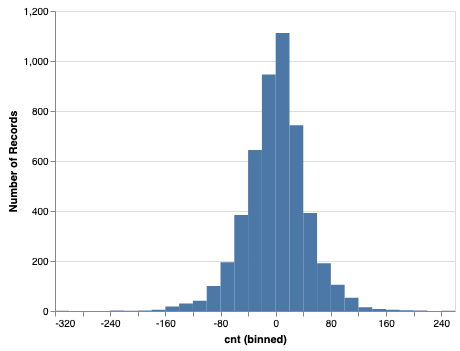

In [52]:
alt.Chart(pd.DataFrame(pd.DataFrame(f2t.y-f2t.pred_y)).iloc[:4999,:])\
.mark_rect().encode(
    x = alt.X("cnt", bin = alt.Bin(maxbins = 40)),
    y = "count()"
)
#TO DO axis label

We can see that we're rarely off by more than 80, but can we make a more specific claim about how good this model is? Let's convert this to a cumulative histogram.

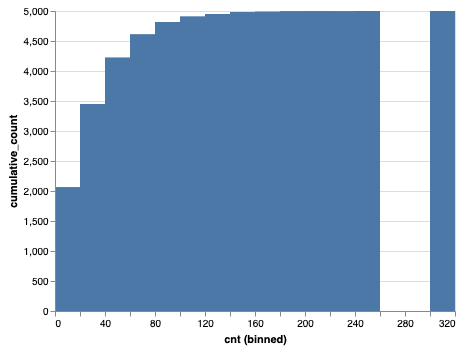

In [57]:
#TO DO read this from a file so as to include all rows
#TO DO percent
alt.Chart(pd.DataFrame(pd.DataFrame(np.abs(f2t.y-f2t.pred_y))).iloc[:4999,:])\
.transform_window(
    sort=[{'field': 'cnt'}],
    frame=[None, 0],
    cumulative_count='count(*)',
)\
.mark_rect().encode(
    x = alt.X("cnt", bin = alt.Bin(maxbins = 20)),
    y = "cumulative_count:Q",
    tooltip = ["cumulative_count:Q", "cnt"]
)

So we can now see that about 93.6% of predictions are off by less than 80, and about 60% are off by less than 35.

You might reasonably wonder if it's possible to build a better model than this. And in fact, it is. The chart below shows the $R^2$ of Gradient Boosting Trees with depth 1-4 as they are grown from 1 to 300 trees each. Performance for both the train and test set is reported. 

In [ ]:
bike_dataset = f2t.get_dataset("bike")
effect_additional_trees = []
train_x, test_x, train_y, test_y\
= train_test_split(bike_dataset["x"], bike_dataset["y"], test_size = 0.3)
for estimators in range(5, 300, 10):
    for depth in range(1,5):
        model = GradientBoostingRegressor(
            n_estimators = estimators, 
            max_depth = depth, 
            learning_rate = 1
        )
        model.fit(train_x, train_y)
        effect_additional_trees.append(
            {
                "number of trees" : estimators,
                "depth" : depth, 
                "train" : r2_score(train_y, model.predict(train_x)),
                "test" : r2_score(test_y, model.predict(test_x))
            }
        )
effect_additional_trees_df = pd.DataFrame(effect_additional_trees)
effect_additional_trees_df = effect_additional_trees_df.melt(
    id_vars = ['number of trees', "depth"],
    var_name = 'set',
    value_name = 'r_squared'
)
effect_additional_trees_df["outcome"] = effect_additional_trees_df.apply(
    lambda x: "depth: " + str(x["depth"]) + ", set: " + x["set"],
    axis = 1
)

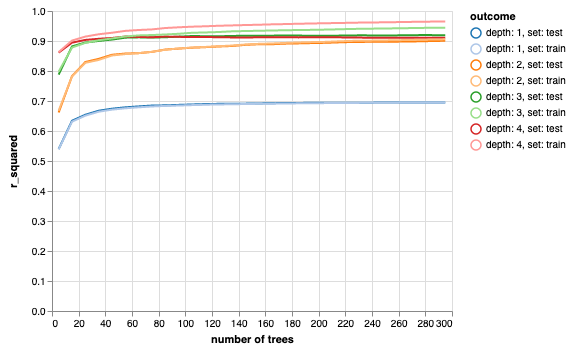

In [58]:
alt.Chart(effect_additional_trees_df).mark_line().encode(
    x = "number of trees:Q",
    y = "r_squared:Q",
    color = alt.Color("outcome", type="nominal", scale = alt.Scale(scheme = "category20")),
    tooltip = [alt.Tooltip("outcome"), alt.Tooltip("r_squared")]
).interactive()

We can clearly see that the 1-deep model performs very poorly. Our 2-deep model takes a bit longer to achieve high performance, but at 200+ trees it's very close to the best performance. And, the performance of the train and test sets are nearly indentical, while the training set for the 4-deep model performs over 0.05 better than its test set, indicating a degree of overfitting.

Likely, smarter hyperparameterization and feature engineering for the 4-deep model would probably produce a better predictor than our 2-deep naive attempt, but we can continue confident that our model has decent performance. As we'll see, we are going to leverage a unique feature of 2-deep decision trees to build our model explanations. 

# Descent into Interpretability
How are we to actually understand a Gradient Boosting model? We need to generate an "explanation" for the model. This can take a lot of different forms - a list of facts or insights, a list of rules that the model follows, a chart, a visual analytics system, a mathematical or logical function, etc. Even the matrices where the model stores its low-level definition are explanations, just not very good ones. We are going to start with some of the more common/naive explanations and then develop some that work better.

Our first explanation is similar to the pseudocode function used in the toy "Lucas" example, but now applied to the first tree in our Gradient Boosting model.

Please note one change - most Gradient Boosting models assume a starting point of the dataset mean, from which point the first tree calculates the error (recall that this "prediction" results in an $R^2$ of 0). The mean in this case is 189.46 riders/hour. So every value below should be added or subtracted to that value, in order to get the actual prediction.

```
def one_tree_of_many():
    IF HOUR OF DAY <= 6:
        IF HOUR OF DAY <= 5: 
            RETURN -164.6
        ELSE:
            RETURN -113.4
    ELSE:
        IF TEMPERATURE_F <= 59.1:
            RETURN -13.5
        ELSE:
            RETURN 126.7
```

The pseudocode function presented above is... fine. The function is transparent, but all of these numbers and splits are hard to understand without context. Basically, we can see here that the model is trying to first reduce its error by predicting low ridership before 6 am, and after that, high ridership on 60+ degree days. We could even guess that 5 AM is the start of the morning commute for some, because that's where the negative effect begins to lessen.

All cool, but a lot to hold in our head at once. Clearly our recall is going to suffer if we're asked to hold more than a tree or two in mind at once. It's wholly impractical if there are 300 trees in the model. We can slightly condense and visualize into something flowcharty like this:

![Styled Flowchart Approach](img/decision_flowchart.png)

This is easier to make sense of at a glance, but even with putting the splits into plain English and returning the actual prediction (rather than just the change from the mean), this approach will not scale well. And, it takes up a lot of space!

Finally, we could take a graphical approach. The chart below is a heatmap of the range of the Temperature and Hour of Day features, and color represents the change from the mean for datapoints in that region. You can hover to get exact values.

In [72]:
#TO DO: filter for show text
single_estimator_slider = wid.IntSlider(
    value = 0,
    min = 0,
    max = 300,
    step = 1,
    continuous_update = False,
    description = "Tree #"
)
ui = wid.HBox([single_estimator_slider])
output = wid.interactive_output(
    f2t.visualize_estimator,
    {
        "estimator_nums" : single_estimator_slider
    }
)
display(ui, output)

#TO DO local scale dropdown
#TO DO 1-based
#TO DO plot datapoints

Output()

There's one big advantage of this approach: we can see the minimum and maximum of a feature's ranges, and so the "threshold" at each split makes more sense in context. The split <=50 degrees would have a different meaning in Florida in the summer vs. Alasks in the winter. In the former it is likely correlated with mornings and nights, whereas in the latter, it might represent a few outlier days. And this need for context will be more pronounced for features that have less inherent meaning to the analyst.

Before we move on, take the time to interact with this cell to get a better sense of the model we are interpreting. You can visualize any single tree in the model by moving the __Tree #__ slider. Note that some trees have one chart, and others two - if both splits in the 2nd layer use the same feature, then we can compactly represent the tree in only one. Look for patterns - for example, later trees generally have smaller "contributions" to the prediction. Why might this be, based on what we know about Gradient Boosting?

## Combining explanations
Still, this approach will not scale well. 300 charts are scarcely better than 300 paragraphs. However, let's take a look at an interesting feature of two of these trees.

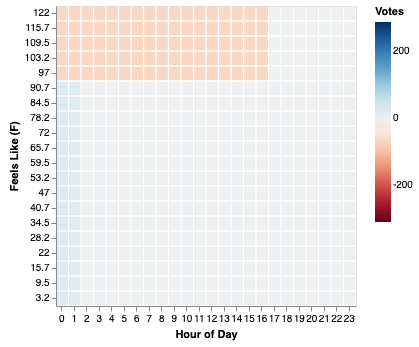

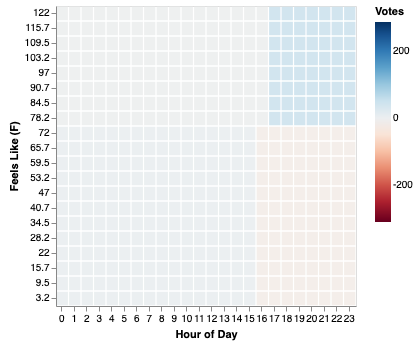

In [85]:
_ = f2t.visualize_estimator(8, print_function_text = False) 
_ = f2t.visualize_estimator(9, print_function_text = False)
#TO DO pass parameter to catch display

These two trees use different split points, on the same features. So the charts we use to display them have the same X and Y axes, and thus the same actual squares in our heatmap. Therefore, we can explain both trees at once with a single chart, by overlaying them on top of each other. The resulting chart will display the sum of the predicted values for each square on the heatmap. 

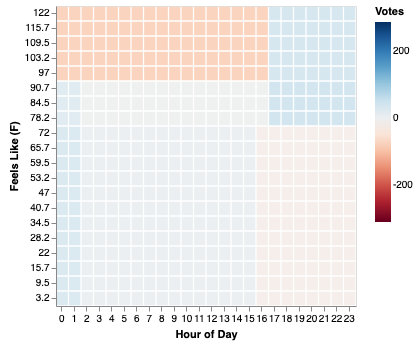

In [80]:
f2t.visualize_estimator([8,9], False, False, False)

Success! By doing this, we've halved the space required to display two trees, with only a slight increase in the complexity of the chart. In fact, I'd argue that it's easier to interpret the two together, because together they more fully describe how the model treats one particular set of variables. And, if we needed to switch to another chart between these two, we'd spend mental overhead on re-orienting ourselves to new axes.

How many charts it would take to visualize every tree in the model, if they were all combined where possible? At a maximum, with 12 features we have $(12*11)/2 = 66$ possible charts.

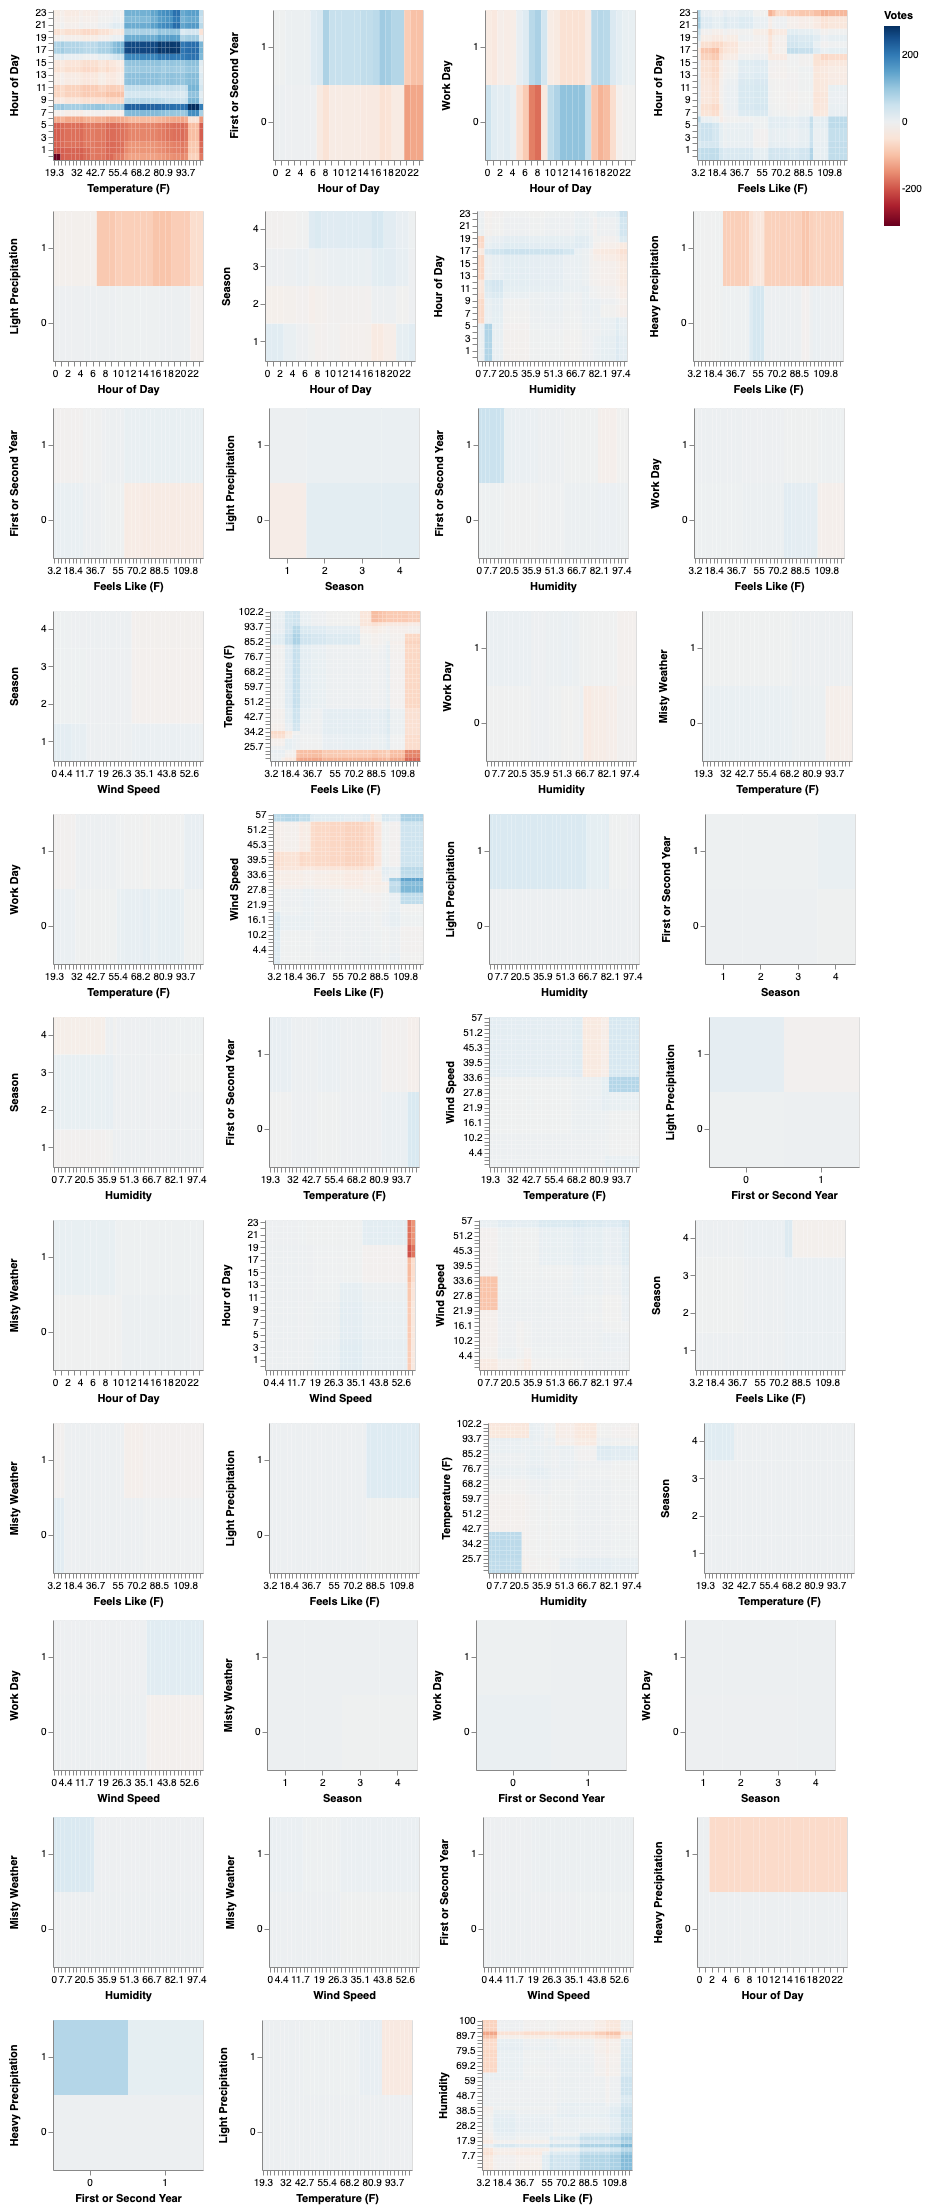

In [122]:
f2t.explain(1.)
f2t.visualize_components(False)

That's 43 charts above, indicating that our model thinks many of the interactions (but not all), are important. You'll notice that these are sorted in descending order of "importance", e.g. the first few have wider color ranges, indicating that they affect the predictions more, whereas the later charts have lighter colors and generally small values. 

Let's take a second to quantify our savings in space and complexity - our model has 300 trees, many of which require 2 charts to represent. A quick calculation should tell us exactly how many charts we would need:

In [91]:
num_charts_required = 0
for estimator_num in range(300):
    chart_components, _, _, _, _ = f2t._extract_components(False, [f2t.model.estimators_[estimator_num]], False)
    num_charts_required += len(chart_components)
print num_charts_required

460


So we've reduced the number of charts from 460 down to 43, which is 9.3% of the original. Not bad! We also could have represented the model with 300 pseudocode blocks or 300 flowcharts.

However, 43 charts is still far too many. We can't yet call this "interpretable". 

And before we even get there, another problem occurs - how do we know that this process has worked correctly? How do we have confidence that these charts faithfully represent our underlying model?

# Model Fidelity

This question is actually going to go to the heart of what's presented here. We'd like to have some assurance that the explanation we extract from the model is actually close to the real thing. But what does this mean? How can we actually calculate fidelity?

One way would be to treat the explanation as a black box, and use it to make predictions from our dataset. We could then compare those predictions to the predictions from our model, and if they are the same, or reasonably close, then we can call the explanation "faithful". In fact, we can calculate the degree to which the explanation is faithful to the model using the $R^2$ metric from before. In essence, we just treat the explanation as a model, and the original model's output as our new training set. We'll return to this concept of an explanation as just a new model later.

But how do we use this explanation, this series of charts, to make a prediction? Well, because this is only lightly abstracted from the underlying decision trees, we can actually use the same method that the model does. 

```
For each datapoint:
    PREDICTION = mean riders/hour of 189.46. 
    For each chart:
        Identify the two features in this chart
        Get the datapoint's values for those two features
        Identify which square of the heatmap the datapoint will fall into based on those values
        PREDICTION += the prediction for that square (the value encoded as color)
    RETURN PREDICTION
```

This method is nigh-identical to the process that the Gradient Boosting model uses to make predictions, except that instead of using a function for each tree to output 300 individual predictions (which are then summed), we use the data structures underlying 43 charts, each of which is just a lookup table mapping feature values to predictions.

This is a little abstract, so let's look at how this works in practice. Below, I've overlaid a sample of datapoints from our dataset onto the Hour of Day/Temperature (F) chart (the first one of the 43 above).

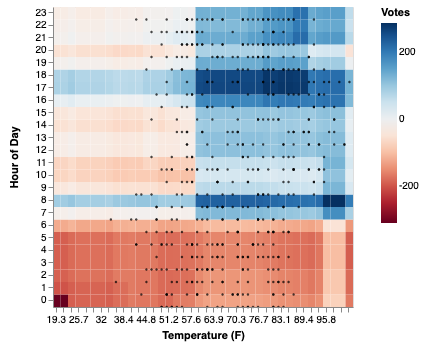

In [121]:
f2t.explain(.5)
f2t.visualize_components(True, 300)

This visualization shows the process of a datapoint "falling into" a cell of the heatmap. Therfore, the chart "outputs" this value for that datapoint, and the datapoint is added to the prediction.

We can also visualize this process from the point of view of a single datapoint. The visualization below is a parallel coordinates chart, in which each line represents a single datapoint, and each column shows its value on a particular feature. Here, the values are not the features of the datapoint itself (e.g. the weather was rainy this hour) but rather the prediction output by a particular chart (e.g. this datapoint fell into a +50 riders square on the "Hour of Day/Temperature(F)" chart). 

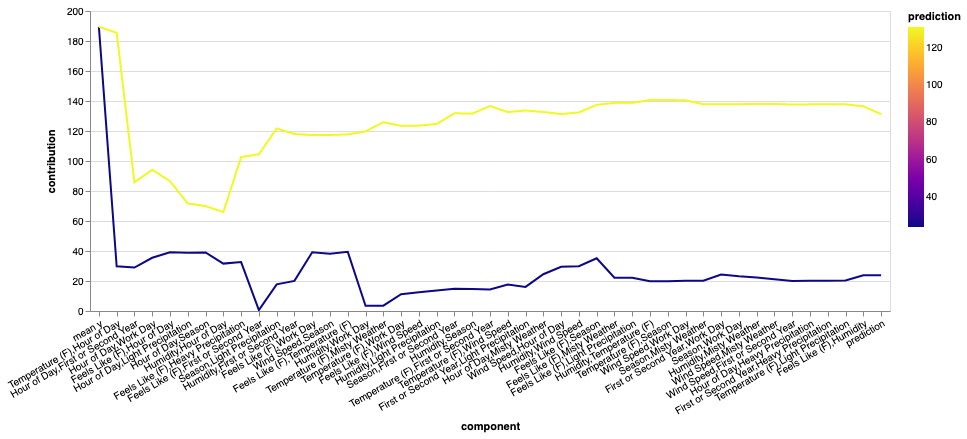

In [134]:
f2t.visualize_datapoints(
    cumulative = True,
    num_datapoints = 2,
    explanation_type = "minimal",
    color_encoding = "prediction",
    auto_display = False
)

This chart visualizes the prediction process for two data points. Note that they each start on the left at the rider/hour mean of 189.46. Then their prediction changes as we sum the output of each chart. As expected, the first few charts cause a major change in the predictions, but eventually the lines flatten out and more gradually approach the final prediction. In general, we see that the last charts don't matter as much. 

The last column is the actual prediction from our Gradient Boosting model, and so a little dip or rise at the end shows how close our explanation go to recreating that prediction. 



In [124]:
#TO DO cache 95% correctly
cumulative_selector = wid.Dropdown(
    options = [('Cumulative Prediction', True), ('Contributions by Feature', False)],
    value = True,
    description = 'View',
)

num_datapoints_slider = wid.IntSlider(
    value = 50,
    min = 1,
    max = 500,
    step = 5,
    description = '# datapoints',
    continuous_update = False,
    orientation = 'horizontal',
    readout = True,
    readout_format = 'd'
)

explanation_selector = wid.Dropdown(
    options = [('95%',"minimal"), ('Full', "full")],
    value = "minimal",
    description = 'Explanation',
)

color_encoding_selector = wid.Dropdown(
    options = f2t.feature_names + ["prediction", "explanation_loss"],
    value = "prediction",
    description = 'Color By',
)

ui = wid.HBox([cumulative_selector, explanation_selector, color_encoding_selector, num_datapoints_slider])

output = wid.interactive_output(
    f2t.visualize_datapoints,
    {
        "cumulative" : cumulative_selector,
        "num_datapoints" : num_datapoints_slider,
        "explanation_type" : explanation_selector,
        "color_encoding" : color_encoding_selector,
        "auto_display" : wid.fixed(True)
    }
)

display(ui, output)

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdWaWV3Jywgb3B0aW9ucz0oKCdDdW11bGF0aXZlIFByZWRpY3Rpb24nLCBUcnVlKSwgKCdDb250cmlidXRpb25zIGJ5IEZlYXTigKY=


Output()

While this should make sense as a method, we don't even need to understand it in order to assess the explanations's fidelity. It'll be enough to see that the $R^2$ is high when compared to the model's predictions. Let's do that.

In [101]:
#TO DO chart of quartiles accuracy relationship
#TO DO chart of number of charts required vs number of trees
f2t.explain(1.)
f2t.evaluate_explanation()

0.9805473906641202

We get a 0.98 $R^2$ score, which indicates that our explanation faithfully recreates the underlying Gradient Boosting model!

Where does the slight loss come from? One modification that we are making by moving from decision trees to heatmaps is that heatmaps divide each feature into regular ranges, producing the tiles or squares that we see. Because these divisions are regular, they won't capture the _exact_ threshold that the underlying tree uses. In other words, if we used finer divisions in our heatmap, the $R^2$ would approach 1.0. 

However, dividing an axis into 100 tiles takes way longer to calculate, so our current approach (40 tiles) will serve fine. 

# Parsimonious Explanations